In [400]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)
library(logistf)
library(ggfortify)
library(cmprsk)
library(miceadds)
source('../tools.R')
source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools_yanis.R')
source("../../../src/merge_df.R")
source("../../../src/my_toolbox.R")
source("../../../src/my_components.R")
source("../../../src/my_utils.R")
source("../../../src/ggstyles.R")
source("../../../src/my_hotspots.R")

###


# theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [4]:
df_aml <- read.table("../../clustering/clustering_Final_1/df_final_full_component.tsv")
df_gen_mds <- read.table("df_mut_hotspot_cut5.tsv",sep="\t",header = T)
df_clin_mds <- read.table("df_clinical_cyto_selected_process_ippsr.tsv",sep="\t",header = T)
rownames(df_clin_mds) <- df_clin_mds$LEUKID
df_mds <- merge(df_gen_mds,df_clin_mds,by=0)
rownames(df_mds) <- df_mds$Row.names
df_mds <- df_mds[-1]
df_mds <- df_mds[df_mds$os_sample_years>=0,]
df_mds$is_mds_aml <- "no"
df_mds$is_mds_aml[grepl("AML",df_mds$WHO_2016)] <- "yes"
df_mds$chemo <- "no"
df_mds$chemo[( grepl("arab",df_mds$type_of_dmt, ignore.case=T) | grepl("cyta",df_mds$type_of_dmt, ignore.case=T) |
        grepl("citarabine",df_mds$type_of_dmt, ignore.case=T) | grepl("fluda",df_mds$type_of_dmt, ignore.case=T) |
        grepl("ice",df_mds$type_of_dmt, ignore.case=T) | grepl("chemo",df_mds$type_of_dmt, ignore.case=T))] <- "yes"



In [5]:
dd <- df_mds
dd$comp_sample_years = pmin(dd$os_sample_years, dd$aml_sample_years)
dd$comp_status = "censor"
dd$comp_status[dd$os_status==1] = "death"
dd$comp_status[dd$aml_status==1] = "aml"
dd$comp_status = factor(dd$comp_status, levels=c("censor","aml","death"))
table(dd$comp_status)

gg_competingrisks.cuminc <- function(fit, gnames = NULL, gsep=" ",
                                    coef = 1.96, conf.int = FALSE, line.size=1, group.levels=NULL) {
    
  # -- fit is from cuminc --  #
  if (!is.null(fit$Tests))
    fit <- fit[names(fit) != "Tests"]
  fit2 <- lapply(fit, `[`, 1:3)
  if (is.null(gnames)) gnames <- names(fit2)
  fit2_list <- lapply(seq_along(gnames), function(ind) {
    df <- as.data.frame(fit2[[ind]])
    df$name <- gnames[ind]
    df
  })
  time <- est <- event <- group <- NULL
  df <- do.call(rbind, fit2_list)
  df$event <- sapply(strsplit(df$name, split=gsep), `[`, 2)
  df$group <- sapply(strsplit(df$name, split=gsep), `[`, 1)
  df$std <- std <- sqrt(df$var)
  if (!is.na(group.levels)) {
      df$group = factor(df$group, levels=group.levels)
  }

  df <- df[df$event=="aml",]

  pl <-  ggplot(df, aes(time, est, color=group)) + geom_line(size=line.size) + ylab("Cumulative incidence of AMLt") + xlab("Years") + theme_survminer()

  if (conf.int) {
    pl <- pl + geom_ribbon(aes(ymin = est - coef*std, ymax=est + coef*std, fill = event), alpha = 0.2, linetype=0)
  }

  return(pl)
}




censor    aml  death 
  1682    558   1079 

# IDH2 Hotspots

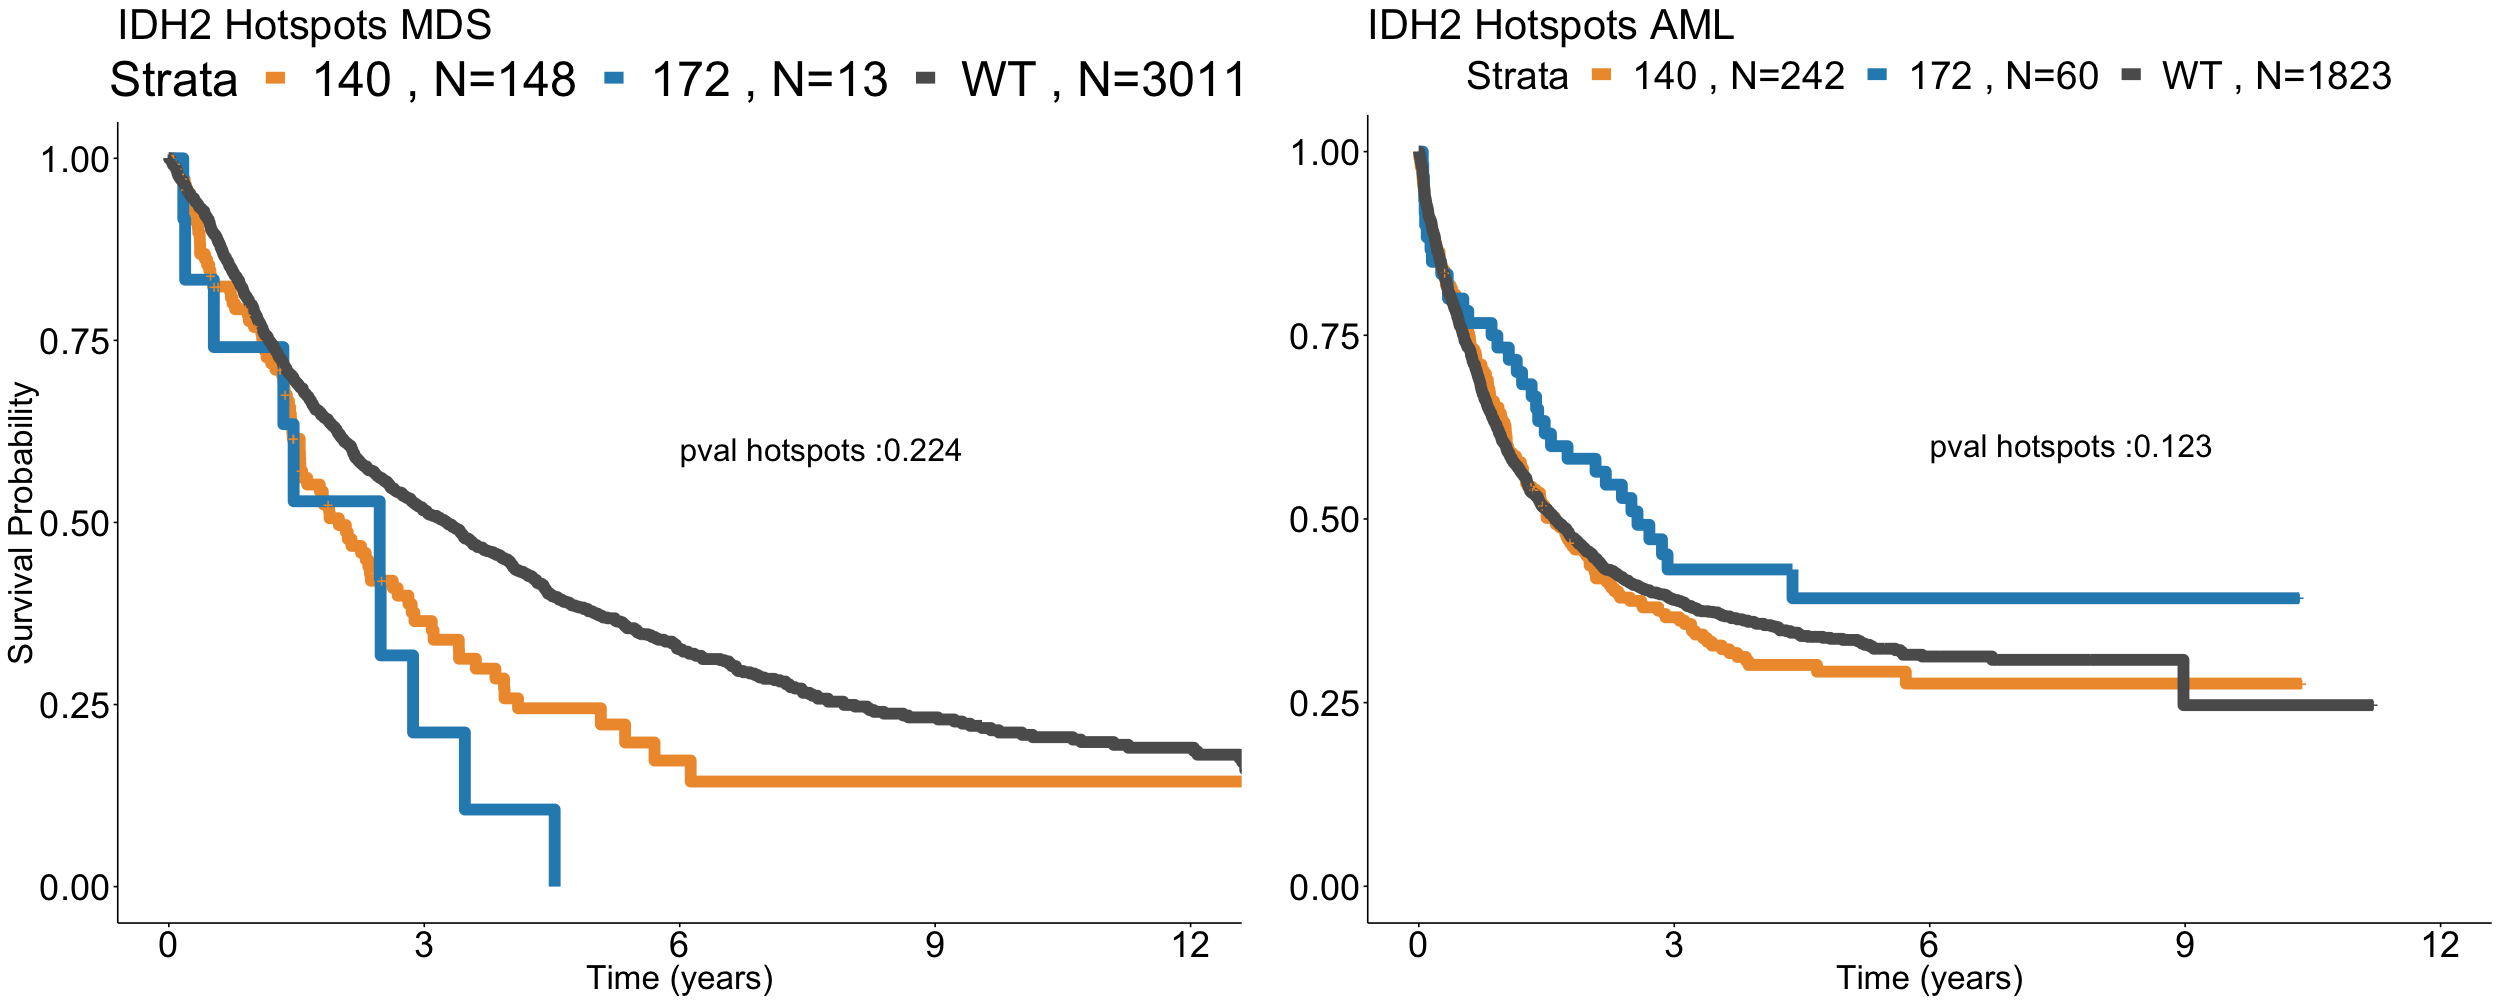

In [7]:
set_notebook_plot_size(25,10)

tmp_mds <- df_mds
tmp_mds$comparison <- ifelse(tmp_mds$IDH2_140==1,"140",
                        ifelse(tmp_mds$IDH2_172==1,"172","WT"))
res <- pairwise_survdiff(Surv(os_sample_years, os_status)~comparison,data = tmp_mds[tmp_mds$comparison %in% c("140","172"),])
surv_object <- Surv(time = tmp_mds$os_sample_years, event = tmp_mds$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_mds)
p <- plot_surv_curves(fit,legend="top",submain="IDH2 Hotspots MDS",vals=c("#EE9937","#2b8cbe","#5C5C5C"),y="Survival Probability",p=paste("pval hotspots :",round(res$p.value[1],3),sep=""),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,font.legend=35)


tmp_aml <- df_aml
tmp_aml$comparison <- ifelse(tmp_aml$IDH2_p.R140==1,"140",
                        ifelse(tmp_aml$IDH2_p.R172==1,"172","WT"))
res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp_aml[tmp_aml$comparison %in% c("140","172"),])
surv_object <- Surv(time = tmp_aml$os, event = tmp_aml$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_aml)
q <- plot_surv_curves(fit,legend="top",submain="IDH2 Hotspots AML",vals=c("#EE9937","#2b8cbe","#5C5C5C"),y="",p=paste("pval hotspots :",round(res$p.value[1],3),sep=""),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

# U2AF1 Hotspots

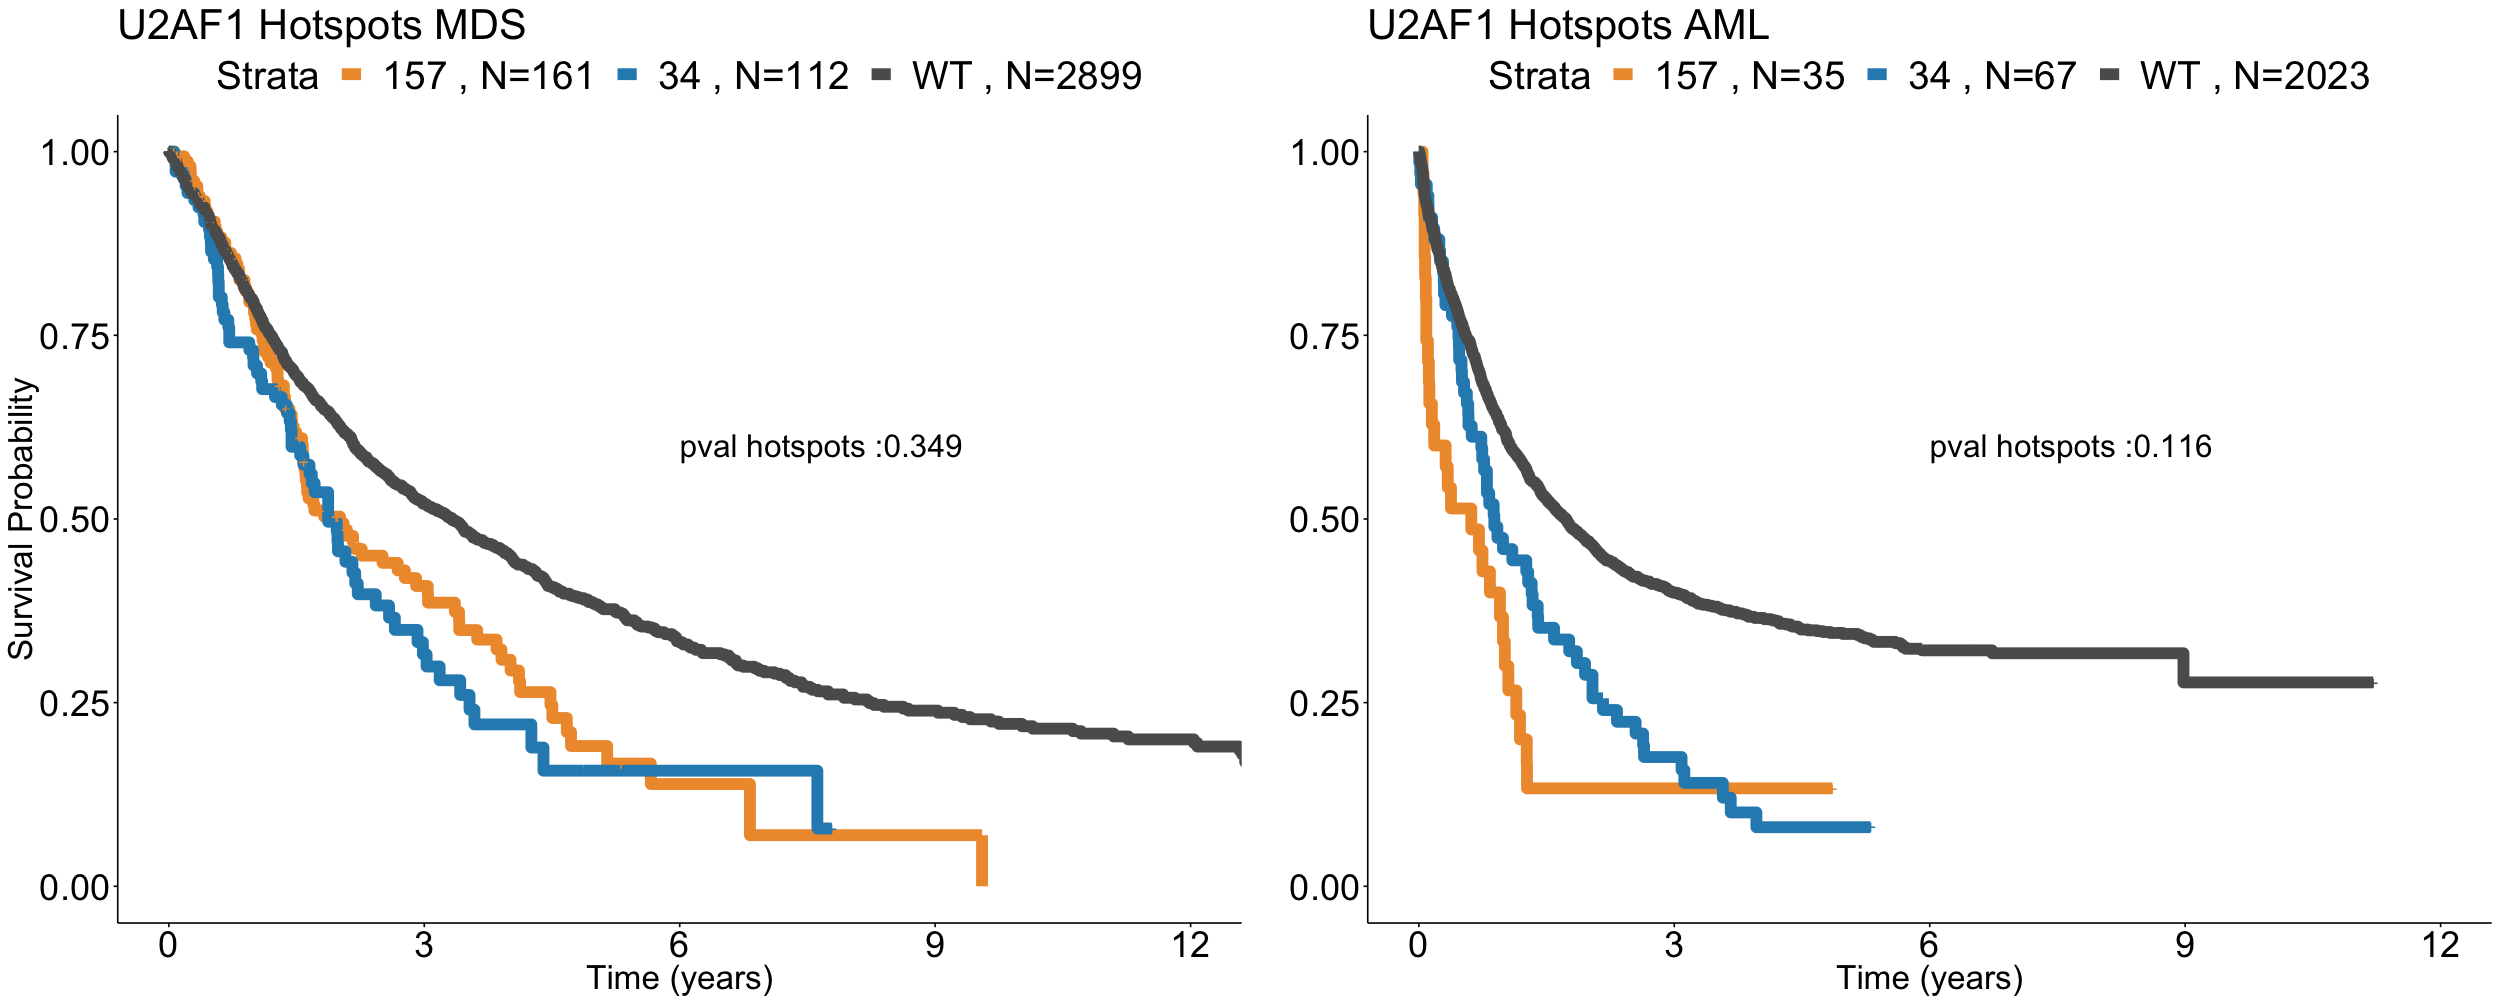

In [192]:
set_notebook_plot_size(25,10)

tmp_mds <- df_mds
tmp_mds$comparison <- ifelse(tmp_mds$U2AF1_157==1,"157",
                        ifelse(tmp_mds$U2AF1_34==1,"34","WT"))
res <- pairwise_survdiff(Surv(os_sample_years, os_status)~comparison,data = tmp_mds[tmp_mds$comparison %in% c("157","34"),])
surv_object <- Surv(time = tmp_mds$os_sample_years, event = tmp_mds$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_mds)
p <- plot_surv_curves(fit,legend="top",submain="U2AF1 Hotspots MDS",vals=c("#EE9937","#2b8cbe","#5C5C5C"),y="Survival Probability",p=paste("pval hotspots :",round(res$p.value[1],3),sep=""),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3)


tmp_aml <- df_aml
tmp_aml$comparison <- ifelse(tmp_aml$U2AF1_p.Q157==1,"157",
                        ifelse(tmp_aml$U2AF1_p.S34==1,"34","WT"))
res <- pairwise_survdiff(Surv(os, os_status)~comparison,data = tmp_aml[tmp_aml$comparison %in% c("157","34"),])
surv_object <- Surv(time = tmp_aml$os, event = tmp_aml$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_aml)
q <- plot_surv_curves(fit,legend="top",submain="U2AF1 Hotspots AML",vals=c("#EE9937","#2b8cbe","#5C5C5C"),y="",p=paste("pval hotspots :",round(res$p.value[1],3),sep=""),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3)

grid.arrange(p$plot,q$plot,nrow=1)

# NPM1 Curves

In [298]:
res
res1


	Pairwise comparisons using Log-Rank test 

data:  tmp_mds[tmp_mds$comparison %in% c("MUT_chemo", "MUT"), ] and comparison 

          MUT 
MUT_chemo 0.42

P value adjustment method: BH 


	Pairwise comparisons using Log-Rank test 

data:  tmp_mds[tmp_mds$comparison %in% c("MUT", "WT"), ] and comparison 

   MUT   
WT 0.0096

P value adjustment method: none 

In [361]:
table(dd$comp_status)


censor    aml  death 
  1682    558   1079 

In [402]:
set_notebook_plot_size(25,25)

tmp_mds <- df_mds
tmp_mds$comparison <- ifelse(tmp_mds$NPM1==1 & tmp_mds$chemo=="yes","MUT_chemo",
                             ifelse(tmp_mds$NPM1==1 & tmp_mds$chemo=="no","MUT","WT"))
surv_object <- Surv(time = tmp_mds$os_sample_years, event = tmp_mds$os_status)
res <- pairwise_survdiff(Surv(os_sample_years, os_status)~comparison,data = tmp_mds[tmp_mds$comparison %in% c("MUT_chemo","MUT"),])
res_wt <- pairwise_survdiff(Surv(os_sample_years, os_status)~comparison,data = tmp_mds[tmp_mds$comparison %in% c("MUT","WT"),])
fit <- survfit(surv_object ~ comparison, data = tmp_mds)
p <- plot_surv_curves(fit,legend="top",submain="NPM1 MDS stratified by chemo",y="Survival Probability",vals=c("#EE9937","#870C14","#5C5C5C","#2b8cbe"),pval=F,pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,risk.tab = T,font.legend=30,legend.title="",xlab="Years")
plot_p <- p$plot+ #+ annotate("text",label=paste("pval MUT +- chemo =",round(res$p.value[1],3),sep=""),x=8,y=0.6,size=8) + 
                   #annotate("text",label=paste("pval MUT vs WT =",round(res_wt$p.value[1],3),sep=""),x=8,y=0.7,size=8)+
annotate("segment",color="#EE9937",x=5,xend=6.5,y=1,yend=1,size=1.8) +
annotate("text",label="vs",y=1,x=7.1,size=10) +
annotate("segment",color="#870C14",x=7.7,xend=9.2,y=1,yend=1,size=1.8) +
annotate("text",label=paste("p =",round(res$p.value[1],3),sep=""),x=10.7,y=1,size=10) +

annotate("segment",color="#EE9937",x=5,xend=6.5,y=0.9,yend=0.9,size=1.8) +
annotate("text",label="vs",y=0.9,x=7.1,size=10) +
annotate("segment",color="#5C5C5C",x=7.7,xend=9.2,y=0.9,yend=0.9,size=1.8) +
annotate("text",label=paste("p =",round(res_wt$p.value[1],3),sep=""),x=10.5,y=0.9,size=10)

                                






tmp = dd
tmp = tmp[ !grepl("AML",tmp$WHO_2016) , ]# EXCLUDE AML PATIENTS for AMLt analysis
tmp$comparison <- ifelse(tmp$NPM1==1,"MUT","WT")
cmfit = with(tmp,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
tlg = table(tmp$comparison[!is.na(tmp$comp_sample_years)])
myleg = paste0(" ", names(tlg)," (N=",tlg,")  ")

cmfit.test = with(tmp,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
ptAMLt = cmfit.test$Tests["aml","pv"]

cr <- gg_competingrisks.cuminc(cmfit,line.size=2.8,group.levels=c("MUT","WT"))+scale_color_manual(values=c("#EE9937","#5C5C5C"),labels=myleg)+scale_x_continuous(breaks=seq(0, 12,3),limits=c(0,12))+
theme(legend.key.width = unit(1.5,"cm"), legend.title = element_text(size=20),legend.text = element_text(size=20))+theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(ptAMLt,6)," by Gray's test"),x=6,y=0.6,size=10)

tmp_mds <- df_mds[df_mds$chemo=="no",]
tmp_mds$comparison <- ifelse(tmp_mds$NPM1==1,"MUT","WT")
surv_object <- Surv(time = tmp_mds$os_sample_years, event = tmp_mds$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_mds)
p <- plot_surv_curves(fit,legend="top",submain="NPM1 MDS ",y="Survival",vals=c("#EE9937","#5C5C5C"),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,risk.tab = T,font.legend=30)



tmp_aml <- df_aml
tmp_aml$comparison <- ifelse(tmp_aml$NPM1==1,"MUT","WT")
surv_object <- Surv(time = tmp_aml$os, event = tmp_aml$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_aml)
q <- plot_surv_curves(fit,legend="top",submain="NPM1 AML",vals=c("#EE9937","#5C5C5C"),y="",pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,font.legend=30,legend.title="",xlab="Years")





png("NPM1_AML_MDS.png",width=6000,height=2000,res=250)
grid.arrange(plot_p,q$plot,nrow=1)
dev.off()

277 cases omitted due to missing values
277 cases omitted due to missing values


pdf 
  2

# Competing Risk

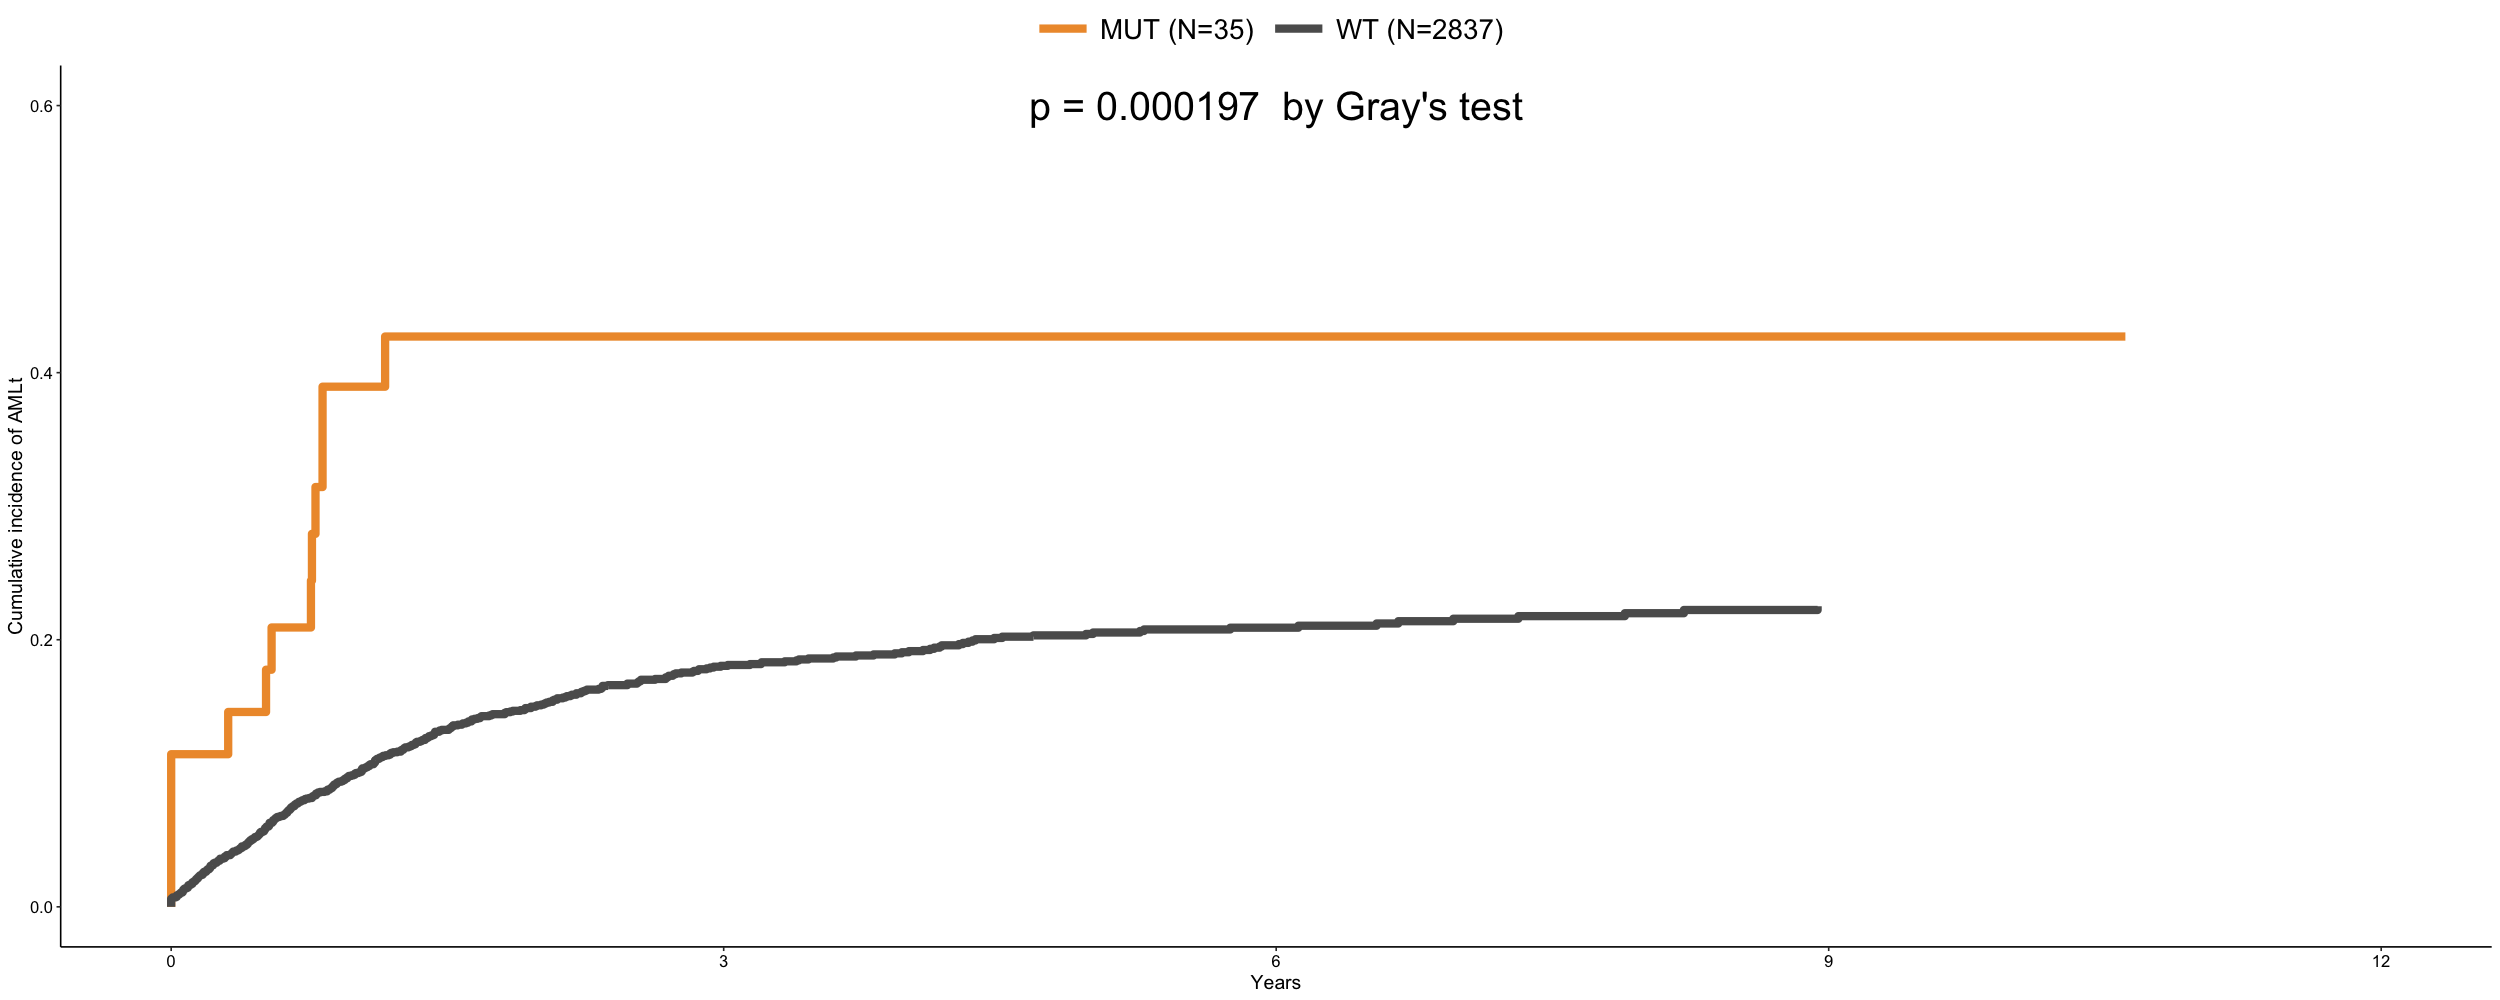

In [358]:
cr

# CHR SPLICEOSOME COMPONENTS COMPARISON MDS AML

In [158]:
load.Rdata("dncomp2.RData","spliceosome_mds")
spliceosome_mds$component <- "MDS"

spliceosome_aml <- read.table("../hdp2_data.tsv")
spliceosome_aml <- spliceosome_aml[spliceosome_aml$second_hdp_initial_predicted_component==1,c(1:154,162)]
spliceosome_aml$NRAS <- pmin(1,spliceosome_aml$NRAS_p.G12_13 + spliceosome_aml$NRAS_p.Q61_62 + spliceosome_aml$NRAS_other)
spliceosome_aml$plus8 <- spliceosome_aml$add_8
spliceosome_aml$MLL_PTD <- spliceosome_aml$MLL
spliceosome_aml$CEBPA <- pmin(1,spliceosome_aml$CEBPA_bi + spliceosome_aml$CEBPA_mono)
spliceosome_aml$FLT3_ITD <- spliceosome_aml$ITD
spliceosome_aml$IDH2_140 <- spliceosome_aml$IDH2_p.R140
spliceosome_aml$del7 <- spliceosome_aml$del_7
spliceosome_aml$plus13 <- spliceosome_aml$add_13
spliceosome_aml$plu21 <- spliceosome_aml$add_21
spliceosome_aml$IDH2_172 <- spliceosome_aml$IDH2_p.R172
spliceosome_aml$U2AF1_157 <- spliceosome_aml$U2AF1_p.Q157
spliceosome_aml$del20q <- spliceosome_aml$del_20
spliceosome_aml$U2AF1_34 <- spliceosome_aml$U2AF1_p.S34
spliceosome_aml <- data.frame(event=colnames(spliceosome_aml[,c(1:154,156:167)]),count=colSums(spliceosome_aml[,c(1:154,156:167)]),freq=100*colSums(spliceosome_aml[,c(1:154,156:167)])/nrow(spliceosome_aml),component="AML")
rownames(spliceosome_aml)<- NULL

In [166]:
spliceosome <- rbind(spliceosome_aml[spliceosome_aml$event %in% intersect(spliceosome_aml$event,spliceosome_mds$event),],spliceosome_mds[spliceosome_mds$event %in% intersect(spliceosome_aml$event,spliceosome_mds$event),])
spliceosome$separation <- "Cytos"
spliceosome$separation[grepl("^[[:upper:]]", spliceosome$event)] <- "Genes"
spliceosome$separation <- factor(spliceosome$separation, levels = c("Genes", "Cytos"))

In [167]:
p <- ggplot(spliceosome, aes(x=event, y=freq, fill=component))+
      geom_bar(stat="identity")+facet_grid(component~separation,scales = "free_x", space = "free_x")+
theme(strip.text = element_text(face="bold", size=20,lineheight=5.0),
    strip.background = element_rect( colour="black",size=1),legend.position="none")+ylab("Frequency")+xlab("")+theme(plot.title = element_text(hjust = 0.5,size=20,face="bold"),
                                                                                                                     axis.text.x = element_text(angle = 90, hjust = 1, size=ifelse(length(comp)>1,20,30),face="bold"),axis.text.y = element_text(size=20,face="bold"))+
         theme(axis.title.y = element_text(size = 20, angle = 90, vjust = 0.25,face="bold"))+
            scale_fill_manual(values=c("#59A08B","#2b8cbe"))+theme(legend.position = "none")+ylab("Frequency")+xlab("")

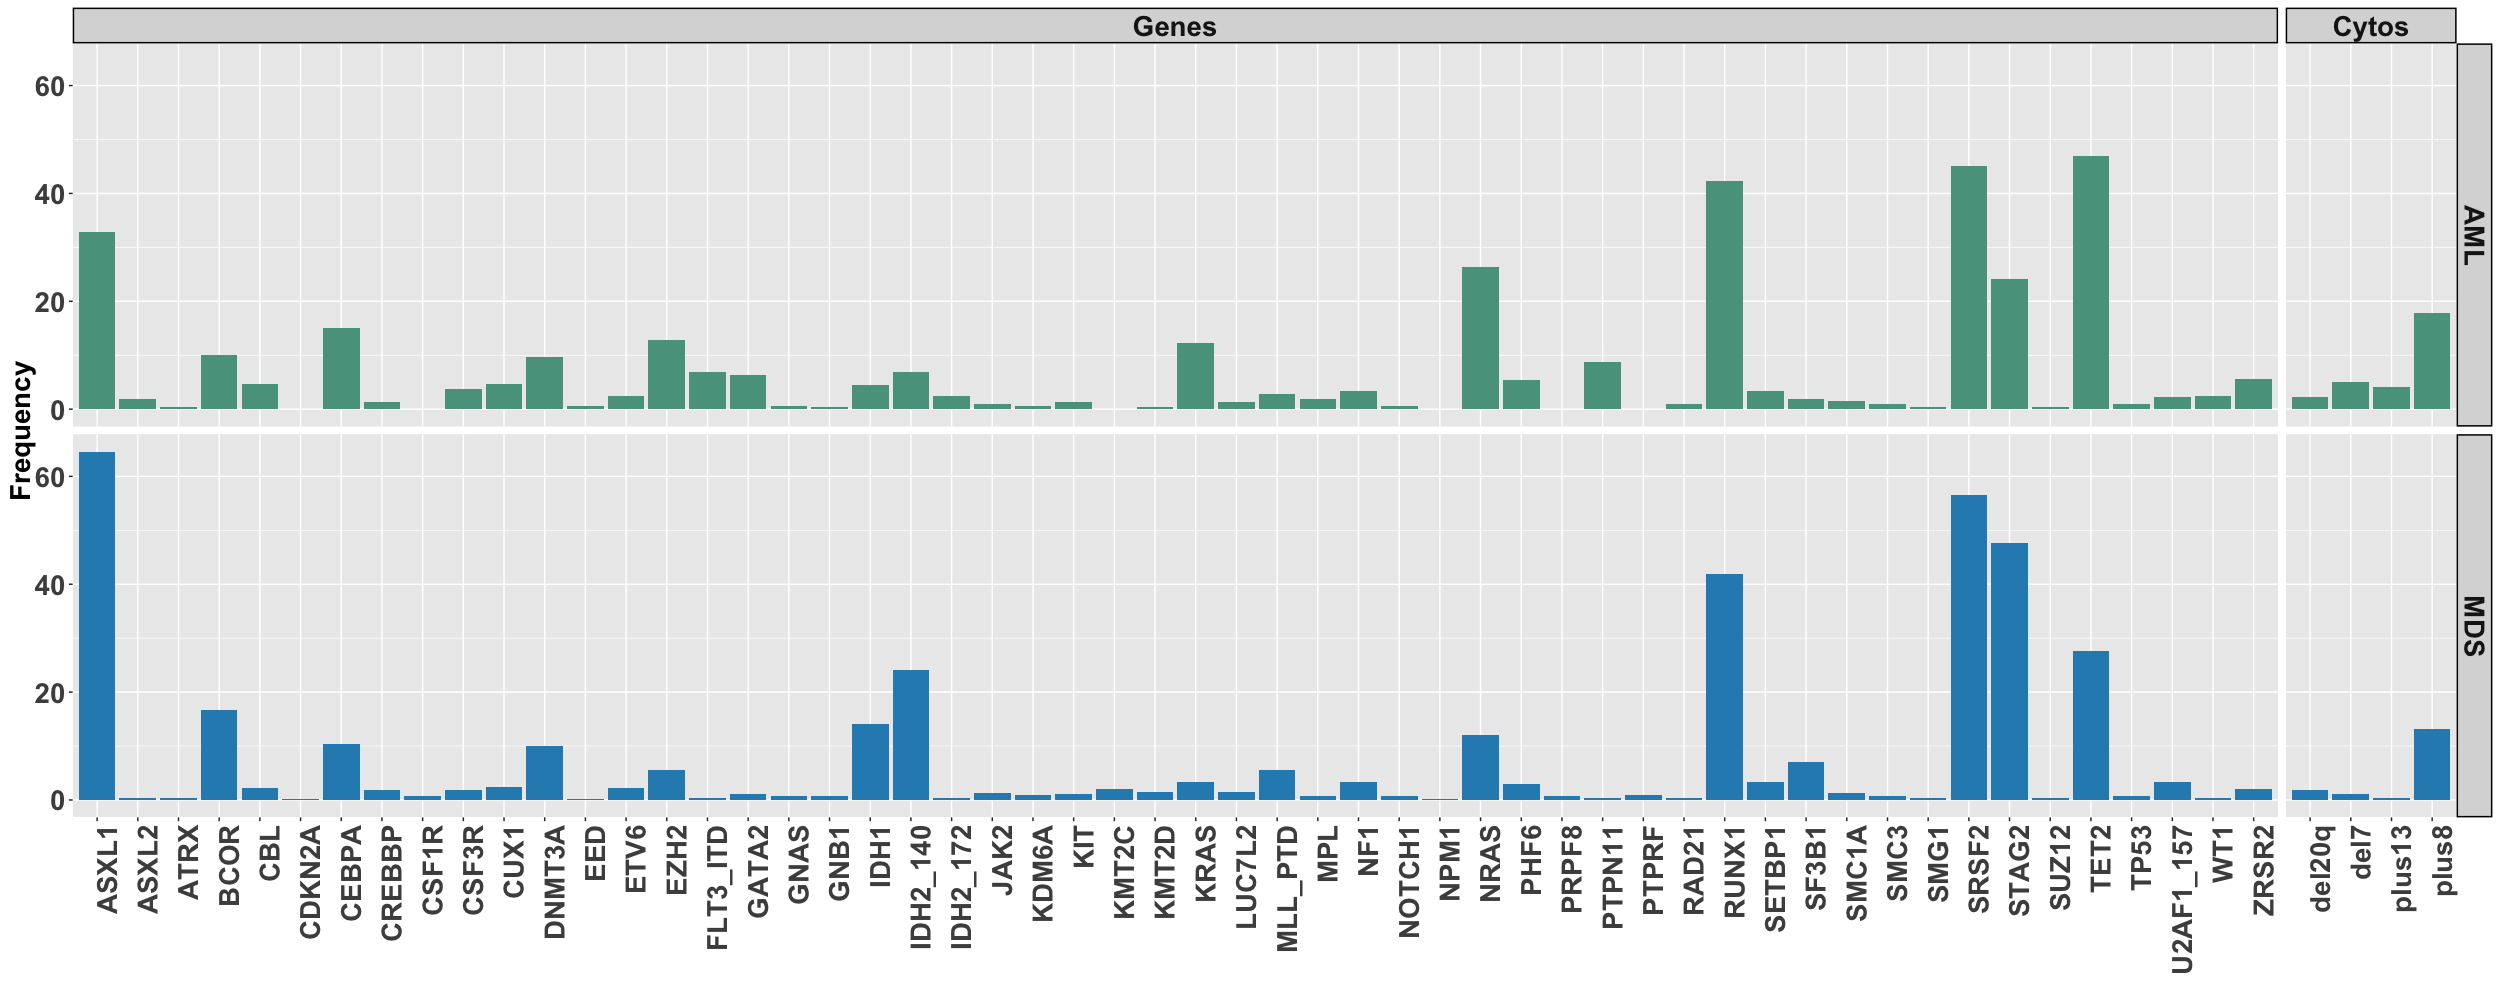

In [168]:
p

# ANALYSIS ALL OTHER GENES TO SPOT DIFFERENCES 

In [171]:
df_aml_common <- df_aml
df_aml_common$NRAS <- pmin(1,df_aml_common$NRAS_p.G12_13 + df_aml_common$NRAS_p.Q61_62 + df_aml_common$NRAS_other)
df_aml_common$plus8 <- df_aml_common$add_8
df_aml_common$MLL_PTD <- df_aml_common$MLL
df_aml_common$CEBPA <- pmin(1,df_aml_common$CEBPA_bi + df_aml_common$CEBPA_mono)
df_aml_common$FLT3_ITD <- df_aml_common$ITD
df_aml_common$IDH2_140 <- df_aml_common$IDH2_p.R140
df_aml_common$del7 <- df_aml_common$del_7
df_aml_common$plus13 <- df_aml_common$add_13
df_aml_common$plu21 <- df_aml_common$add_21
df_aml_common$IDH2_172 <- df_aml_common$IDH2_p.R172
df_aml_common$U2AF1_157 <- df_aml_common$U2AF1_p.Q157
df_aml_common$del20q <- df_aml_common$del_20
df_aml_common$U2AF1_34 <- df_aml_common$U2AF1_p.S34

In [186]:
cols_interesting <- c("ASXL2","CBL","CUX1","ETV6","GATA2","KIT","MPL","NF1","NPM1","PTPN11","RAD21","SF3B1","SMC1A","TET2","ZRSR2","NRAS")
pdf("test.pdf",width=20)
for (event in cols_interesting){
    tmp_mds <- df_mds
    tmp_mds$comparison <- ifelse(tmp_mds[,event],"MUT","WT")
    surv_object <- Surv(time = tmp_mds$os_sample_years, event = tmp_mds$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp_mds)
    p <- plot_surv_curves(fit,legend="top",submain=paste(event," MDS ",""),y="Survival Probability",vals=c("#EE9937","#5C5C5C"),pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,risk.tab = T,font.legend=30)



    tmp_aml <- df_aml_common
    tmp_aml$comparison <- ifelse(tmp_aml[,event]==1,"MUT","WT")
    surv_object <- Surv(time = tmp_aml$os, event = tmp_aml$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp_aml)
    q <- plot_surv_curves(fit,legend="top",submain=paste(event," AML ",""),vals=c("#EE9937","#5C5C5C"),y="",pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,font.legend=30)

    grid.arrange(p$plot,q$plot,nrow=1)
}
dev.off()

pdf 
  2

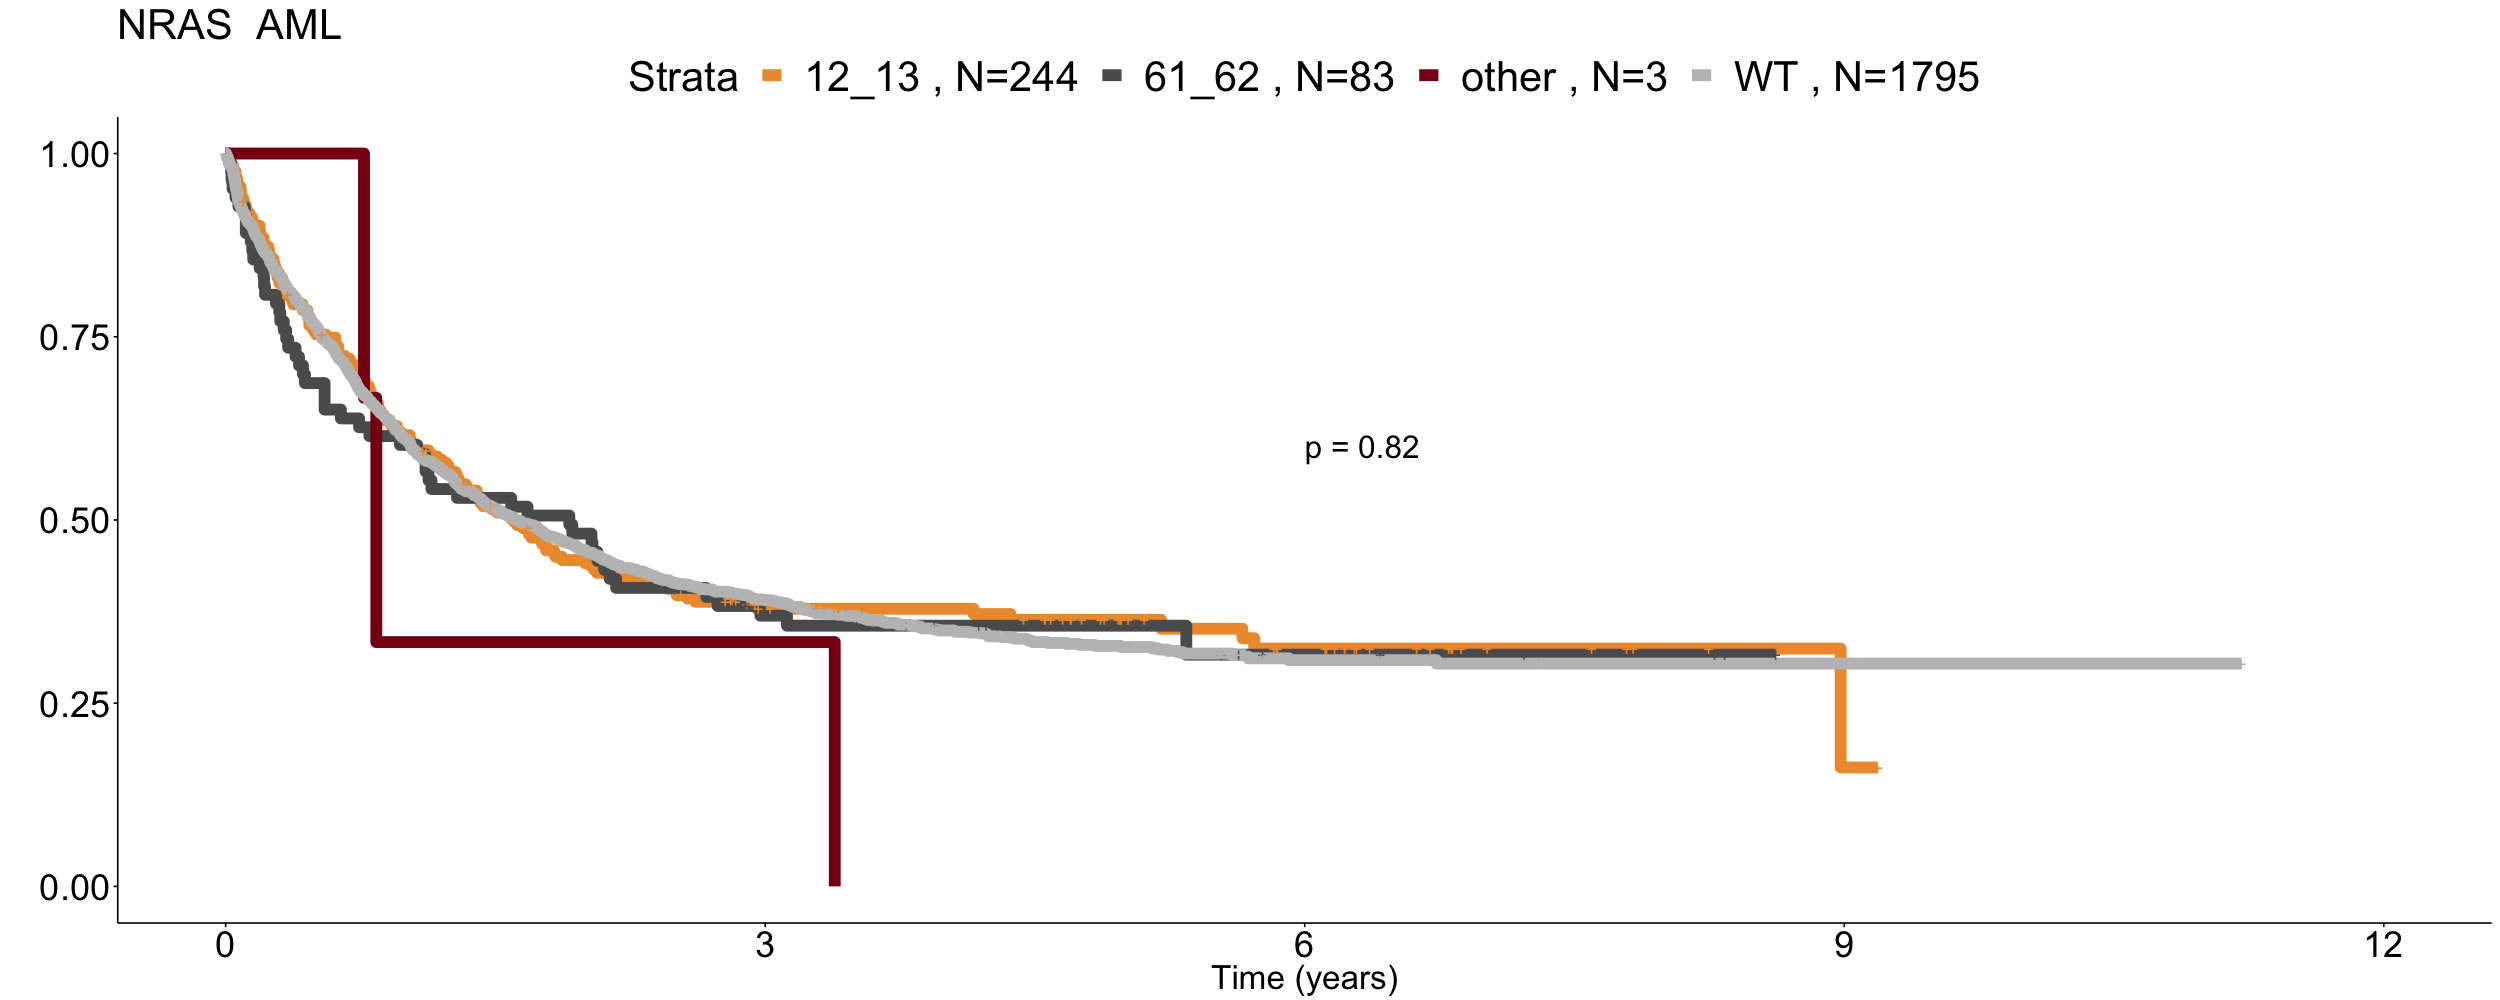

In [188]:
tmp_aml <- df_aml
tmp_aml$comparison <- ifelse(tmp_aml$NRAS_p.Q61_62==1,"61_62",
                            ifelse(tmp_aml$NRAS_p.G12_13==1,"12_13",
                                   ifelse(tmp_aml$NRAS_other==1,"other","WT")))
surv_object <- Surv(time = tmp_aml$os, event = tmp_aml$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp_aml)
q <- plot_surv_curves(fit,legend="top",submain=paste(event," AML ",""),y="",pval.coord=c(6,0.6),xlim=c(0,12),break.time.by=3,font.legend=30)

q

# ELLI PLOT REQUEST

In [322]:
library("readxl")                 

In [323]:
my_data <- read_excel("DataForYanis2.xlsx")
# my_data$Gene <- gsub("_.*$", "", data$Gene)

In [324]:
my_data_aml <- my_data[my_data$DISEASE=="AML",]
colnames(my_data_aml)[colnames(my_data_aml)=="VAF"] <- "VAF_AML"
my_data_aml$DISEASE <- NULL
my_data_mds <- my_data[my_data$DISEASE=="MDS",]
colnames(my_data_mds)[colnames(my_data_mds)=="VAF"] <- "VAF_MDS"
my_data_mds$DISEASE <- NULL
data <- merge(my_data_aml,my_data_mds,by=c("Gene","Case"))

In [357]:
set_notebook_plot_size(15,15)
png("test.png",width=5000,height=5000,res=250)
ggplot(data, aes(x=VAF_MDS, y=VAF_AML))  + geom_point(col="#0072B2", size=10)+xlim(0,100)+ylim(0,100) +facet_wrap(~Case)+geom_abline(intercept = 0, slope = 1,col="black",face="bold",se=F,size=5,linetype=1)+
geom_label_repel(aes(label = Gene),size=15,color="#0072B2",face="bold",    box.padding = unit(1.35, "lines"),
    point.padding = unit(1.5, "lines"),
    segment.color = 'grey50')+theme_bw() +
theme(  panel.background = element_rect(fill = NA),
  panel.grid.major = element_line(colour = "black"),
  panel.ontop = TRUE,strip.text = element_text(face="bold", size=50,lineheight=5.0),
    strip.background = element_rect( colour="black",size=1),legend.position="none")+xlab("")+theme(axis.text.x = element_text(size=40,face="bold",color="black"),axis.text.y = element_text(size=40,face="bold",color="black"))+
         theme(axis.title.y = element_text(size = 50, angle = 90, vjust = 0.25,face="bold"),axis.title.x = element_text(size = 50,vjust = 0.25,face="bold"))+
            scale_fill_manual(values=colors)+theme(legend.position = "none")+ylab("VAF AML")+xlab("VAF MDS")
dev.off()
#   geom_text(fontface = "bold",position=position_jitter(width=1,height=1))

pdf 
  2

In [255]:
my_data[my_data$Case== "Case 3",]
my_data[my_data$Case== "Case 4",]

Case,Gene,VAF,DISEASE
Case 3,FLT3_p.D835Y,45,AML
Case 3,FLT3_p.D835Y,0,MDS
Case 3,DNMT3A_p.I670fs*43,48,AML
Case 3,TET2_p.?,46,AML
Case 3,NPM1_p.W288fs*12,40,AML
Case 3,NRAS_p.G12A,37,MDS
Case 3,NRAS_p.G12A,0,AML
Case 3,DNMT3A_p.I670fs*43,51,MDS
Case 3,TET2_p.?,46,MDS
Case 3,NPM1_p.W288fs*12,46,MDS


Case,Gene,VAF,DISEASE
Case 4,NRAS_p.G12D,61,AML
Case 4,NPM1_p.W288fs*12,45,AML
Case 4,RAD21_p.?,42,AML
Case 4,NRAS_p.G12D,39,MDS
Case 4,NPM1_p.W288fs*12,41,MDS
Case 4,RAD21_p.?,43,MDS


In [256]:
nrow(my_data[my_data$Gene %in% unique(my_data$Gene),])

[1] 34

In [314]:
gsub("_.*$", "", data$Gene)

[1] "DNMT3A" "DNMT3A" "DNMT3A" "DNMT3A" "FLT3"   "NPM1"   "NPM1"   "NPM1"  
 [9] "NPM1"   "NRAS"   "NRAS"   "NRAS"   "NRAS"   "RAD21"  "RAD21"  "TET2"  
[17] "TET2"